# Automated ML

In [1]:
import os
import joblib
import requests
import json
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import Counter
from pprint import pprint

from azureml.core import Workspace, Experiment, Dataset 
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core import Environment
from azureml.core import ScriptRunConfig
from azureml.core.model import Model
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice,Webservice
from azureml.interpret import ExplanationClient
from azureml.train.automl import AutoMLConfig

from azureml.widgets import RunDetails

## Dataset
The dataset in this notebook is from Kaggle (https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers).
A bank is interested to know if a customer will churn given demographic and several other payment history data. The CSV file is uploaded in the datasets and imported here. 

In [3]:
ws = Workspace.from_config()

experiment_name = 'BanckChurner'
experiment=Experiment(ws, experiment_name)

datastore=ws.get_default_datastore()
dataset=Dataset.Tabular.from_delimited_files(datastore.path('UI/02-28-2021_030313_UTC/BankChurners.csv'))

In [4]:
df=dataset.to_pandas_dataframe()
df.head()

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0  Existing Customer            45      M                3     High School   
1  Existing Customer            49      F                5        Graduate   
2  Existing Customer            51      M                3        Graduate   
3  Existing Customer            40      F                4     High School   
4  Existing Customer            40      M                3      Uneducated   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue              39   
1         Single  Less than $40K          Blue              44   
2        Married    $80K - $120K          Blue              36   
3        Unknown  Less than $40K          Blue              34   
4        Married     $60K - $80K          Blue              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000

In [5]:
df.describe().T

count         mean          std     min       25%  \
Customer_Age              10127.0    46.325960     8.016814    26.0    41.000   
Dependent_count           10127.0     2.346203     1.298908     0.0     1.000   
Months_on_book            10127.0    35.928409     7.986416    13.0    31.000   
Total_Relationship_Count  10127.0     3.812580     1.554408     1.0     3.000   
Months_Inactive_12_mon    10127.0     2.341167     1.010622     0.0     2.000   
Contacts_Count_12_mon     10127.0     2.455317     1.106225     0.0     2.000   
Credit_Limit              10127.0  8631.953698  9088.776650  1438.3  2555.000   
Total_Revolving_Bal       10127.0  1162.814061   814.987335     0.0   359.000   
Avg_Open_To_Buy           10127.0  7469.139637  9090.685324     3.0  1324.500   
Total_Amt_Chng_Q4_Q1      10127.0     0.759941     0.219207     0.0     0.631   
Total_Trans_Amt           10127.0  4404.086304  3397.129254   510.0  2155.500   
Total_Trans_Ct            10127.0    64.858695    23.472570    10.0    45.000   
Total_Ct_Chng_Q4_Q1       10127.0     0.712222     0.238086     0.0     0.582   
Avg_Utilization_Ratio     10127.0     0.274894     0.275691     0.0     0.023   

                               50%        75%        max  
Customer_Age                46.000     52.000     73.000  
Dependent_count              2.000      3.000      5.000  
Months_on_book              36.000     40.000     56.000  
Total_Relationship_Count     4.000      5.000      6.000  
Months_Inactive_12_mon       2.000      3.000      6.000  
Contacts_Count_12_mon        2.000      3.000      6.000  
Credit_Limit              4549.000  11067.500  34516.000  
Total_Revolving_Bal       1276.000   1784.000   2517.000  
Avg_Open_To_Buy           3474.000   9859.000  34516.000  
Total_Amt_Chng_Q4_Q1         0.736      0.859      3.397  
Total_Trans_Amt           3899.000   4741.000  18484.000  
Total_Trans_Ct              67.000     81.000    139.000  
Total_Ct_Chng_Q4_Q1          0.702      0.818      3.714  
Avg_Utilization_Ratio        0.176      0.503      0.999

Client ID should be dropped from the dataset since it is ID and does not carry any information. Moreover, when deploying to new customers, customer ID might be outside of the range we train the model with.

In [6]:
for col in df.columns:
    if df[col].dtype=='O':
        print("There are {} unique values in column {} as {}".format(len(Counter(df[col])),col,Counter(df[col])),"\n")

There are 2 unique values in column Attrition_Flag as Counter({'Existing Customer': 8500, 'Attrited Customer': 1627}) 

There are 2 unique values in column Gender as Counter({'F': 5358, 'M': 4769}) 

There are 7 unique values in column Education_Level as Counter({'Graduate': 3128, 'High School': 2013, 'Unknown': 1519, 'Uneducated': 1487, 'College': 1013, 'Post-Graduate': 516, 'Doctorate': 451}) 

There are 4 unique values in column Marital_Status as Counter({'Married': 4687, 'Single': 3943, 'Unknown': 749, 'Divorced': 748}) 

There are 6 unique values in column Income_Category as Counter({'Less than $40K': 3561, '$40K - $60K': 1790, '$80K - $120K': 1535, '$60K - $80K': 1402, 'Unknown': 1112, '$120K +': 727}) 

There are 4 unique values in column Card_Category as Counter({'Blue': 9436, 'Silver': 555, 'Gold': 116, 'Platinum': 20}) 



We also need to check if there is any missing value in each column.

In [7]:
df.isnull().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [8]:
dataset=dataset.drop_columns('CLIENTNUM')

In [9]:
training, validation=dataset.random_split(percentage=0.8, seed=23)
training.to_pandas_dataframe().head()

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0  Existing Customer            45      M                3     High School   
1  Existing Customer            49      F                5        Graduate   
2  Existing Customer            51      M                3        Graduate   
3  Existing Customer            40      M                3      Uneducated   
4  Existing Customer            44      M                2        Graduate   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue              39   
1         Single  Less than $40K          Blue              44   
2        Married    $80K - $120K          Blue              36   
3        Married     $60K - $80K          Blue              21   
4        Married     $40K - $60K          Blue              36   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         5                       1                      0   
4                         3                       1                      2   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        4716.0                    0           4716.0                 2.175   
4        4010.0                 1247           2763.0                 1.376   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3              816              28                2.500                  0.000  
4             1088              24                0.846                  0.311

Provision a comupute cluster or an existing one.

In [10]:
cpu_cluster_name="comute33"
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2', max_nodes=4)
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## AutoML Configuration
The problem in this project is a classification problem. We use 5 fold cross validation AUC_weighted score to rank models from the AUTOML runs. Runs are executed using 5 concurrent iterations. We also use auto featurization and let AzureMl to do the feature engineering. To save money and time, a 15 minutees limit is used for AutoML.

In [11]:

compute_target = ws.compute_targets[cpu_cluster_name]
automl_settings = {
    "experiment_timeout_minutes": 15,
    "n_cross_validations": 5,
    "primary_metric": "AUC_weighted",
    "max_concurrent_iterations": 5
    
}

# TODO: Put your automl config here
automl_config = AutoMLConfig(task="classification",
    training_data=training,
    label_column_name='Attrition_Flag',
    featurization= 'auto',
    compute_target=compute_target,
    **automl_settings)

In [12]:
#Submit your experiment
remote_run = experiment.submit(automl_config)

Running on remote.


## Run Details
The details of the AutoML runs are as following:

In [13]:
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Best Model
Best model of the AutoMl is used for further analysis

In [14]:
automl_best_run, fitted_automl_model = remote_run.get_output() 

run_dict = automl_best_run.get_details()

print("Best Run ID: ", run_dict["runId"])
print("---"*10)
print("AutoML best run AUC_weighted: ", automl_best_run.get_metrics(name="AUC_weighted"))
print("---"*10)
print("Metrics: ", automl_best_run.get_metrics())
print("---"*10)
print("Fitted model and its hyperparameters : ", fitted_automl_model.steps[-1])
print("AutoML Run Summary: ", remote_run.summary())

Best Run ID:  AutoML_2b0c7901-a271-435c-82f7-a62a1d9f3dab_0
------------------------------
AutoML best run AUC_weighted:  {'AUC_weighted': 0.9916554534222624}
------------------------------
Metrics:  {'balanced_accuracy': 0.9335694389160325, 'average_precision_score_micro': 0.9957405837637051, 'f1_score_macro': 0.9414606933839087, 'recall_score_micro': 0.9689757760311013, 'weighted_accuracy': 0.9820749941124483, 'log_loss': 0.0848147259748738, 'AUC_weighted': 0.9916554534222624, 'precision_score_weighted': 0.9686278205067598, 'recall_score_weighted': 0.9689757760311013, 'precision_score_macro': 0.9499621473674307, 'average_precision_score_weighted': 0.9928146172006445, 'f1_score_micro': 0.9689757760311013, 'f1_score_weighted': 0.9686867994950317, 'norm_macro_recall': 0.8671388778320649, 'AUC_micro': 0.9956359340756482, 'average_precision_score_macro': 0.9811270700018646, 'AUC_macro': 0.9916554534222624, 'matthews_correlation': 0.8833417579807555, 'precision_score_micro': 0.968975776031

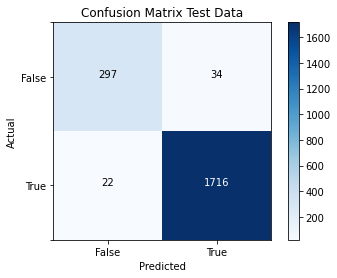

In [15]:
X_test_df = validation.drop_columns(columns=['Attrition_Flag']).to_pandas_dataframe()
y_test_df = validation.keep_columns(columns=['Attrition_Flag'], validate=True).to_pandas_dataframe()
y_pred = fitted_automl_model.predict(X_test_df)



cf =confusion_matrix(y_test_df.values,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

In [55]:
custom_featurizer = fitted_automl_model.named_steps['datatransformer']
df = custom_featurizer.get_featurization_summary()
pd.DataFrame(data=df)

RawFeatureName TypeDetected Dropped  EngineeredFeatureCount  \
0               Customer_Age  Categorical      No                      45   
1                     Gender  Categorical      No                       1   
2            Dependent_count  Categorical      No                       6   
3            Education_Level  Categorical      No                       7   
4             Marital_Status  Categorical      No                       4   
5            Income_Category  Categorical      No                       6   
6              Card_Category  Categorical      No                       4   
7             Months_on_book  Categorical      No                      44   
8   Total_Relationship_Count  Categorical      No                       6   
9     Months_Inactive_12_mon  Categorical      No                       7   
10     Contacts_Count_12_mon  Categorical      No                       7   
11              Credit_Limit      Numeric      No                       1   
12       Total_Revolving_Bal      Numeric      No                       1   
13           Avg_Open_To_Buy      Numeric      No                       1   
14      Total_Amt_Chng_Q4_Q1      Numeric      No                       1   
15           Total_Trans_Amt      Numeric      No                       1   
16            Total_Trans_Ct      Numeric      No                       1   
17       Total_Ct_Chng_Q4_Q1      Numeric      No                       1   
18     Avg_Utilization_Ratio      Numeric      No                       1   

                             Transformations  
0       [StringCast-CharGramCountVectorizer]  
1   [ModeCatImputer-StringCast-LabelEncoder]  
2       [StringCast-CharGramCountVectorizer]  
3       [StringCast-CharGramCountVectorizer]  
4       [StringCast-CharGramCountVectorizer]  
5       [StringCast-CharGramCountVectorizer]  
6       [StringCast-CharGramCountVectorizer]  
7       [StringCast-CharGramCountVectorizer]  
8       [StringCast-CharGramCountVectorizer]  
9       [StringCast-CharGramCountVectorizer]  
10      [StringCast-CharGramCountVectorizer]  
11                             [MeanImputer]  
12                             [MeanImputer]  
13                             [MeanImputer]  
14                             [MeanImputer]  
15                             [MeanImputer]  
16                             [MeanImputer]  
17                             [MeanImputer]  
18                             [MeanImputer]

## Model Deployment

The best model of the AutoML is not deployed in this notebook. Instead, the model from the hyperparameter_tuning notebook is deployed. Execute the following cells if you want to deploy the best model from the AutoML.

In [17]:
automl_best_run.download_file('outputs/model.pkl', 'AutoML artifact/automl_best_model.pkl')
automl_best_run.download_file('outputs/scoring_file_v_1_0_0.py', 'AutoML artifact/score_aml.py')
automl_best_run.download_file('automl_driver.py', 'AutoML artifact/automl_driver.py')

model = Model.register(workspace = ws,
                        model_path ="AutoML artifact/automl_best_model.pkl",
                        model_name = "automl_best_model")

Registering model automl_best_model


In [ ]:
automl_best_run.download_file('outputs/conda_env_v_1_0_0.yml' , 'env.yml')
env = Environment.from_conda_specification(name='myenv',file_path = 'env.yml')

inference_config = InferenceConfig(entry_script='AutoML artifact/score_aml.py',
                                    environment=env)

deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 1,enable_app_insights = True)
service = Model.deploy(ws, "deploy", [model], inference_config, deployment_config)
service.wait_for_deployment(show_output = True)
print(service.state)

## Log the deployed service

In [ ]:
logs = service.get_logs()
for line in logs.split('\n'):
    print(line)

In [ ]:
data= ({'data':X_test_df[0:2].to_dict(orient='records'),'method':'predict'})
test_sample=json.dumps(data)
output= service.run(test_sample)
print(output)

In [45]:
test_sample = json.dumps(data)
output= service.run(test_sample)
print(output)

['Existing Customer', 'Existing Customer']


In [52]:

scoring_uri=service.scoring_uri
key=''
headers = {'Content-Type': 'application/json'}
# If authentication is enabled, set the authorization header
#headers['Authorization'] = f'Bearer {key}'
data = {"data":
        [
          {'Customer_Age': 62,
 'Gender': 'F',
 'Dependent_count': 0,
 'Education_Level': 'High School',
 'Marital_Status': 'Unknown',
 'Income_Category': 'Less than $40K',
 'Card_Category': 'Blue',
 'Months_on_book': 24,
 'Total_Relationship_Count': 3,
 'Months_Inactive_12_mon': 4,
 'Contacts_Count_12_mon': 1,
 'Credit_Limit': 3313.0,
 'Total_Revolving_Bal': 2517,
 'Avg_Open_To_Buy': 796.0,
 'Total_Amt_Chng_Q4_Q1': 1.047,
 'Total_Trans_Amt': 692,
 'Total_Trans_Ct': 16,
 'Total_Ct_Chng_Q4_Q1': 0.6,
 'Avg_Utilization_Ratio': 0
 }
      ]
    }
test_sample = json.dumps(data)


resp = requests.post(scoring_uri, test_sample, headers=headers)
print(resp.json())

['Attrited Customer']


## Clean Up

In [41]:
service.delete()
print("service deleted")

service deleted
